## Обучаем первую модель на MNIST

План на сегодня: пишем первый пайплайн для обучения

1. Пытаемся понять, какие компоненты нам нужны для обучения любой модели
2. Выясняем, что многое уже есть в Pytorch
3. Собираем наш первый скрипт для обучения на датасете MNIST

### 1. Разбираемся с данными

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

#### 1.1. Организуем доступ к данным с `torch.utils.data.Dataset`

Датасет в pytorch - это объект класса, в котором реализовано два обязательных метода: `__getitem__(self, index: int)` (получение одиночного примера по индексу) и `__len__(self)` (получение общего количества примеров). Этих методов достаточно, чтобы разбивать датасет на минибатчи  - это работу делает класс `torch.utils.DataLoader` с помощью различных семплеров, с ними мы понакомимся позже

In [1]:
import torch

torch.manual_seed(42)

In [2]:
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, n: int) -> None:
        super().__init__()
        self.data = torch.arange(n * 3).view((n, 3))
        self.labels = torch.randint(0, 5, size=(n,))

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.data[index], self.labels[index]

    def __len__(self) -> int:
        return len(self.data)


dataset = MyDataset(n=10)
print(dataset[0])
print(len(dataset))

(tensor([0, 1, 2]), tensor(2))
10


Итерируемся по датасету:

In [3]:
dataset = MyDataset(10)
for i in range(len(dataset)):
    print(dataset[i])

(tensor([0, 1, 2]), tensor(3))
(tensor([3, 4, 5]), tensor(4))
(tensor([6, 7, 8]), tensor(0))
(tensor([ 9, 10, 11]), tensor(4))
(tensor([12, 13, 14]), tensor(1))
(tensor([15, 16, 17]), tensor(2))
(tensor([18, 19, 20]), tensor(0))
(tensor([21, 22, 23]), tensor(0))
(tensor([24, 25, 26]), tensor(2))
(tensor([27, 28, 29]), tensor(1))


#### 1.2. Пакуем данные в батчи с `torch.utils.data.Dataloader`

У `torch.utils.data.Dataloader` много аргументов, на практике чаще всего используются
- `dataset` - объект, поддерживающий методы `__getitem__` и `__len__` (вопрос: можно ли передать список? словарь? множество?)
- `batch_size` - размер мини-батча
- `shuffle` - нужно ли перетасовать индексы перед нарезкой на минибатчи (это всегда стоит делать с обучающими данными, почему?)
- `num_workers` - количество процессов, которые будут загружать данные - иногда позволяет ускорить обучение (подумайте, в каком случае?)

In [4]:
from torch.utils.data import DataLoader

my_loader = DataLoader(
    dataset=dataset,
    batch_size=4,
    shuffle=True,
    # drop_last=
)

In [5]:
for i, batch in enumerate(my_loader):
    x, y = batch
    if i == 0:
        print(x)
        print(y)

tensor([[24, 25, 26],
        [ 6,  7,  8],
        [21, 22, 23],
        [15, 16, 17]])
tensor([2, 0, 0, 2])


#### 1.3. Посмотрим на MNIST

- какие атрибуты есть у объекта `torchvision.datasets.MNIST`?
- как выглядит одно наблюдение?

In [6]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),  # что это?
)
test_dataset = datasets.MNIST(
    "data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [7]:
isinstance(train_dataset, Dataset)

True

In [8]:
x, y = train_dataset[0]
print(x.shape)
print(y)

torch.Size([1, 28, 28])
5


**Задание 1 (1 балл)**. Используя `matplotlib`, выведите по одному примеру изображения для всех классов

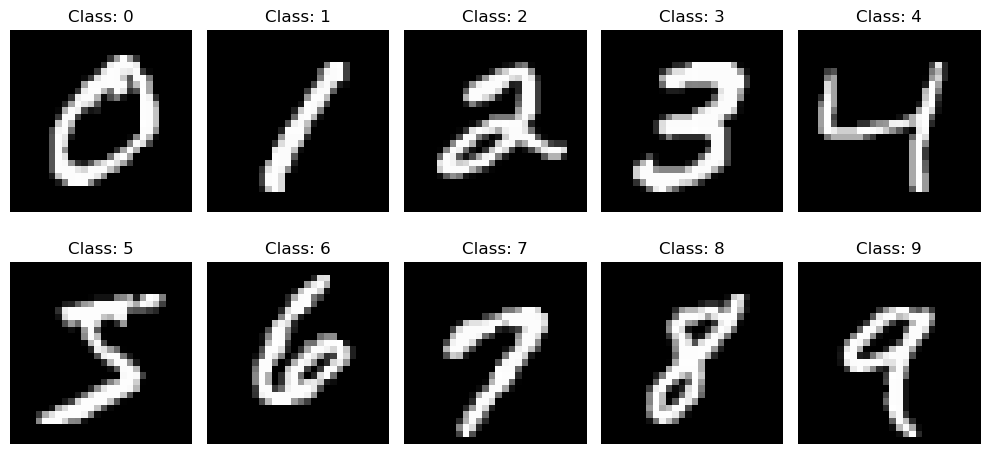

In [9]:
import matplotlib.pyplot as plt

examples = {i: None for i in range(10)}

for img, label in train_dataset:
    if examples[label] is None:
        examples[label] = img
    if all(examples[i] is not None for i in range(10)):
        break

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(examples[i].squeeze(), cmap='gray')
    plt.title(f'Class: {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Попробуем получить минибатч:

In [10]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Что возвращает `iter()`?

In [11]:
batch: tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Со свёрточными сетями мы познакомимся позже, сейчас же мы будем экспериментировать с обычными полносвязными сетями, но для этого нам нужно будет преобразовать форму батча из `(batch_size, channels, width, height)` в `(batch_size, channels * width * height)`:

**Задание 2 (1 балл)**. Есть несколько способов изменить форму (shape) тензора. Приведите все знаковые вам способы привести батч с изображениями в форму `(batch_size, channels * width * height)`

In [12]:
batch_size, channels, width, height = x.shape
input_dim = channels * width * height

batch[0] = batch[0].view(batch_size, input_dim)
batch[0] = batch[0].view(-1, input_dim)
batch[0] = torch.reshape(batch[0], (batch_size, input_dim))
batch[0] = torch.reshape(batch[0], (-1, input_dim))
### ВАШ ХОД

Ура, с данными вроде разобрались! Теперь разберёмся с моделью

### 2. Реализуем модель с помощью `torch.nn.Module`

#### 2.1. Описываем параметры модели и прямой проход

Для простоты будем строить небольшую нейронку из двух полносвязных слоёв и `tanh` в качестве функции активации.

Какие параметры должны быть в линейном слое?

In [13]:
hidden_dim = 128  # размерность скрытого слоя
n_classes = 10

# первый слой
w1 = torch.randn((input_dim, hidden_dim), requires_grad=True)
b1 = torch.randn(hidden_dim, requires_grad=True)

# второй слой
w2 = torch.randn((hidden_dim, n_classes), requires_grad=True)
b2 = torch.randn(n_classes, requires_grad=True)

h = x.flatten(1) @ w1 + b1
print(h.grad_fn)
print(h.shape)

h = h @ w2 + b2
print(h.grad_fn)
print(h.shape)

torch.Size([4, 128])
torch.Size([4, 10])


In [14]:
h

tensor([[ 6.1924e+01,  6.5752e+01, -2.8816e+02, -3.6014e+01, -1.6586e+02,
         -1.0979e+02, -1.0025e+02,  2.2467e+01, -1.5655e+02, -1.9430e+02],
        [-2.7328e+01, -1.3860e+02, -2.6277e+02,  3.7322e+01, -2.2849e+02,
         -6.6558e+01,  7.9254e+01, -1.4702e+02, -2.4030e+02, -2.6586e+02],
        [-1.3193e+02, -5.0985e+01, -2.6483e+02,  4.8768e+01, -1.0452e+02,
          2.5061e+01, -1.2468e+02,  3.0136e+01, -1.7629e+02, -2.0046e+02],
        [-5.6786e+01,  7.4243e-02, -5.9197e+01,  5.4188e+01, -1.3124e+01,
          3.2730e+01, -1.0442e+01, -4.3471e+01, -9.4881e+01,  2.4784e+01]],
       grad_fn=<AddBackward0>)

Из этих выходных данных нам хотелось бы получить вероятностное распределение над возможными классами, то есть нужно как-то нормализовать эти активации, для этого обычно используется функция `softmax`:

In [15]:
z = torch.randn(10)
torch.softmax(z, 0)
# zz = torch.exp(z) / torch.exp(z).sum()
# zz.sum()

tensor([0.0420, 0.2254, 0.0424, 0.1480, 0.1133, 0.0393, 0.0123, 0.0224, 0.2780,
        0.0768])

Применим к нашим данным:

In [16]:
h.softmax(dim=1)

tensor([[2.1281e-02, 9.7872e-01, 0.0000e+00, 7.0065e-45, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.5562e-19, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.1524e-19, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 4.7644e-44, 0.0000e+00, 1.0000e+00, 0.0000e+00, 5.0562e-11,
         0.0000e+00, 8.0934e-09, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.1516e-24, 0.0000e+00, 1.0000e+00, 5.8434e-30, 4.7941e-10,
         8.5389e-29, 3.8676e-43, 0.0000e+00, 1.6977e-13]],
       grad_fn=<SoftmaxBackward0>)

Обратите внимание: классы получились совсем не равновероятны, хотя мы ещё не учили модель. Подумайте, почему так произошло?
Подробнее это мы обсудим на следующей практике.

Параметры нашей модели находятся в глобальной области видимости. Решение - спрятать всё внутрь класса-наследника `torch.nn.Module`

#### 2.2. Реализуем двуслойный перцептрон как наследник `nn.Module`

**Задание 3 (1 балл)**. Прочитайте документацию к классам `torch.nn.Module` и `torch.nn.Parameter`. Почему при задании параметров модели не стоит их создавать просто как `torch.tensor(..., requires_grad=True)`?

In [17]:
# Если задавать параметры в модуле, как torch.nn.Parameter(), то они назначаются в качестве атрибутов модуля и автоматически добавляются в список параметров, который 
# появляется в итераторе parameters(). Это может быть полезно, если нам нужно кешировать скрытое состояние сети и не сохранять туда ненужные вспомогательные тензоры.

**Задание 4 (1 балл)**. Чтобы сделать наш модуль рабочим, нужно определить два метода: `__init__` и `forward`. Реализуйте метод `forward`, который возвращает логиты, т. е. выход последнего линейного слоя без применения функции активации `softmax`

In [18]:
class SimpleNet(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int) -> None:
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.randn(input_dim, hidden_dim))
        self.b1 = torch.nn.Parameter(torch.randn(hidden_dim))

        self.w2 = torch.nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.b2 = torch.nn.Parameter(torch.randn(output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        logits = torch.nn.Tanh()(x.flatten(1) @ self.w1 + self.b1) @ self.w2 + self.b2
        return logits

In [19]:
model = SimpleNet(input_dim, hidden_dim, n_classes)
model(x).shape

torch.Size([4, 10])

Параметры модели:

In [20]:
list(model.named_parameters())

[('w1',
  Parameter containing:
  tensor([[-1.2292, -1.0120,  0.4707,  ..., -0.0728, -0.6880, -0.4777],
          [ 0.3049, -0.1532, -0.9360,  ..., -0.4225,  1.4490, -1.4940],
          [-0.2417,  0.1200,  2.0957,  ..., -1.5898, -0.7208, -0.7473],
          ...,
          [ 1.0767,  0.5517, -0.3984,  ..., -1.2501, -0.5982,  1.5680],
          [-0.8215,  0.8184, -1.3175,  ..., -0.2640,  1.2872, -2.1384],
          [-0.9900,  0.2295, -0.0511,  ...,  1.2163, -0.0432,  0.2473]],
         requires_grad=True)),
 ('b1',
  Parameter containing:
  tensor([ 0.0455, -0.4694, -0.6163, -0.9565,  0.9412, -2.0597,  0.8542, -1.0297,
          -0.4305, -0.0911, -0.0372,  0.9671,  0.3460, -0.2004,  1.2349, -0.2132,
           0.3037,  0.6809, -1.4601, -2.1847, -1.1509,  0.6184,  0.1307,  0.6123,
           0.4117,  0.5679, -1.0337,  1.2653, -1.4532, -0.0134,  0.0051,  0.3899,
           1.4850, -0.2099, -1.0838, -0.2242, -0.7229,  0.0957,  0.8528, -1.3629,
           0.2486,  0.4181,  0.9491,  1.0454,  

Вручную обновлять значения многих параметров очень неудобно. К счастью, за нас это сделает оптимизатор

In [22]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


#### 2.1. Считаем ошибку и градиенты на одном минибатче

In [23]:
# получим предсказания и посчитаем ошибку
predictions = model.forward(x)
loss = torch.nn.functional.cross_entropy(predictions, y)
print(loss)
# рассчитаем градиенты и обновим параметры
loss.backward()
optimizer.step()

# не забудем почистить градиенты, мы не хотим их накапливать
optimizer.zero_grad()

tensor(23.9353, grad_fn=<NllLossBackward0>)


**Задание 5 (1 балл)**: Посчитайте значение перекрёстной энтропии самостоятельно по формуле, сверьтесь с результатом выше

In [24]:
# посчитайте ce_loss на основе значений переменных `predictions` и `y`
ce_loss = -torch.mean(torch.nn.functional.one_hot(y, 10) * torch.log_softmax(predictions, dim=1)) * 10 # умножаем на 10, так как 10 колонок
print(ce_loss)
assert torch.allclose(ce_loss, loss), f"{ce_loss} != {loss}"

tensor(23.9353, grad_fn=<MulBackward0>)


### 3. Обучение

#### 3.1. Шаг обучения: что мы делаем с каждым минибатчем данных

In [25]:
def training_step(
    batch: tuple[torch.Tensor, torch.Tensor],
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> tuple[torch.Tensor, torch.Tensor]:
    # прогоняем батч через модель
    x, y = batch
    predictions = model(x)
    # оцениваем значение ошибки
    loss = torch.nn.functional.cross_entropy(predictions, y)
    # обновляем параметры
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # возвращаем значение функции ошибки для логирования
    return loss, predictions

Для тестовых батчей нам не нужны градиенты, поэтому расчёты делаем внутри контекста `torch.no_grad`

In [26]:
def test_step(
    batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module
) -> tuple[torch.Tensor, torch.Tensor]:
    x, y = batch
    with torch.no_grad():
        predictions = model(x)
        # оцениваем значение ошибки
        loss = torch.nn.functional.cross_entropy(predictions, y)
    return loss, predictions

#### 3.2. А теперь: что мы хотим делать в каждой эпохе?

**Задание 6 (2 балла)**: Напишите функцию для запуска одной эпохи (обучающей или тестовой), которая итерируется по минибатчам, обрабатывает их и в конце выводит среднюю ошибку и точность классификации. Запустите обучение на 10-15 эпох, добейтесь точности более 92% на тестовой выборке.

In [27]:
def run_epoch(
    is_train: bool,
    dataloader: DataLoader,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> None:
    
    if is_train:
        model.train()  # Включаем режим обучения
    else:
        model.eval()   # Включаем режим тестирования

    epoch_loss = 0.0
    accuracy = 0
    total_samples = 0

    for batch in dataloader:
        if is_train:
            loss, predictions = training_step(batch, model, optimizer)
        else:
            loss, predictions = test_step(batch, model)

        # Накапливаем значение потерь
        epoch_loss += loss.item()

        # Получаем предсказания классов
        predicted_classes = predictions.argmax(dim=1)
        accuracy += (predicted_classes == batch[1]).sum().item()
        total_samples += batch[1].size(0)
    # Вычисляем среднюю потерю и точность
    epoch_loss = epoch_loss / len(dataloader)
    accuracy =  accuracy / total_samples

    print(f"Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

Создадим модель, оптимизатор и загрузчики данных и запустим обучение:

In [28]:
n_epochs = 15
for i in range(n_epochs):
    print(f"Epoch {i} train:")
    run_epoch(True, train_loader, model, optimizer)
    print(f"Epoch {i} test:")
    run_epoch(False, test_loader, model, optimizer)

Epoch 0 train:
Loss: 1.5844, Accuracy: 0.7651
Epoch 0 test:
Loss: 0.7284, Accuracy: 0.8578
Epoch 1 train:
Loss: 0.6006, Accuracy: 0.8688
Epoch 1 test:
Loss: 0.5277, Accuracy: 0.8817
Epoch 2 train:
Loss: 0.4296, Accuracy: 0.8952
Epoch 2 test:
Loss: 0.4370, Accuracy: 0.8927
Epoch 3 train:
Loss: 0.3497, Accuracy: 0.9084
Epoch 3 test:
Loss: 0.3935, Accuracy: 0.8977
Epoch 4 train:
Loss: 0.3013, Accuracy: 0.9173
Epoch 4 test:
Loss: 0.3612, Accuracy: 0.9055
Epoch 5 train:
Loss: 0.2707, Accuracy: 0.9226
Epoch 5 test:
Loss: 0.3374, Accuracy: 0.9083
Epoch 6 train:
Loss: 0.2477, Accuracy: 0.9290
Epoch 6 test:
Loss: 0.3265, Accuracy: 0.9103
Epoch 7 train:
Loss: 0.2308, Accuracy: 0.9325
Epoch 7 test:
Loss: 0.3104, Accuracy: 0.9127
Epoch 8 train:
Loss: 0.2165, Accuracy: 0.9370
Epoch 8 test:
Loss: 0.3003, Accuracy: 0.9161
Epoch 9 train:
Loss: 0.2050, Accuracy: 0.9396
Epoch 9 test:
Loss: 0.2915, Accuracy: 0.9181
Epoch 10 train:
Loss: 0.1951, Accuracy: 0.9420
Epoch 10 test:
Loss: 0.2887, Accuracy: 0.91